# 图像特效-Gabor滤镜

In [1]:
from scipy import signal
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import scipy.misc as misc
import scipy.ndimage as ndimage

In [2]:
src = cv2.imread('../datas/p3.jpg')
gray = cv2.imread('../datas/p3.jpg',0)
rgb = cv2.cvtColor(src,cv2.COLOR_BGR2RGB)

In [3]:
def kernelFromFunction(size, f):
    """
    Creates a kernel of the given size, populated with values obtained by
    calling the given function.
    :param size: The desired size of the kernel.
    :param f:    The function.
    :returns:    The created kernel.
    """

    kernel = np.empty((size, size))
    for i in range(0, size):
        for j in range(0, size):
            kernel[i, j] = f(i - size / 2, j - size / 2)

    return kernel

In [4]:
def gaborKernel(size, angle, frequency):
    """
    Create a Gabor kernel given a size, angle and frequency.
    Code is taken from https://github.com/rtshadow/biometrics.git
    """

    angle += np.pi * 0.5
    cos = np.cos(angle)
    sin = -np.sin(angle)

    yangle = lambda x, y: x * cos + y * sin
    xangle = lambda x, y: -x * sin + y * cos

    xsigma = ysigma = 4

    return kernelFromFunction(size, lambda x, y:
            np.exp(-(
                (xangle(x, y) ** 2) / (xsigma ** 2) +
                (yangle(x, y) ** 2) / (ysigma ** 2)) / 2) *
            np.cos(2 * np.pi * frequency * xangle(x, y)))

In [5]:
def normalize(image):
    image = np.copy(image)
    image -= np.min(image)
    m = np.max(image)
    if m > 0.0:
        image *= 1.0 / m
    return image

In [21]:
def localNormalize(image, w=32):
    image = np.copy(image)
    height, width = image.shape
    for y in range(0, height, w):
        for x in range(0, width, w):
            image[y:y+w, x:x+w] = normalize(image[y:y+w, x:x+w])

    return image

In [22]:
def binarize(image, w=32):
    """
    Perform a local binarization of an image. For each cell of the given size
    w, the average value is calculated. Every pixel that is below this value,
    is set to 0, every pixel above, is set to 1.
    :param image: The image to be binarized.
    :param w:     The size of the cell.
    :returns:     The binarized image.
    """

    image = np.copy(image)
    height, width = image.shape
    for y in range(0, height, w):
        for x in range(0, width, w):
            block = image[y:y+w, x:x+w]
            threshold = np.average(block)
            image[y:y+w, x:x+w] = np.where(block >= threshold, 1.0, 0.0)

    return image

In [28]:
def sobelKernelX():
    """
    Creates a horizontal Sobel kernel.
    """
    return np.array([[-1,  0,  1],
                     [-2,  0,  2],
                     [-1,  0,  1]])

def sobelKernelY():
    """
    Creates a vertical Sobel kernel.
    """
    return np.array([[-1, -2, -1],
                     [ 0,  0,  0],
                     [ 1,  2,  1]])


In [6]:
def averageFrequency(frequencies):
    """
    Calculate the average frequency in a frequency field.
    """

    frequencies = frequencies[np.where(frequencies >= 0.0)]
    if frequencies.size == 0:
        return -1
    return np.average(frequencies)

In [7]:
def convolve(image, kernel, origin=None, shape=None, pad=True):
    """
    Apply a kernel to an image or to a part of an image.
    :param image:   The source image.
    :param kernel:  The kernel (an ndarray of black and white, or grayvalues).
    :param origin:  The origin of the part of the image to be convolved.
                    Defaults to (0, 0).
    :param shape:   The shape of the part of the image that is to be convolved.
                    Defaults to the shape of the image.
    :param pad:     Whether the image should be padded before applying the
                    kernel. Passing False here will cause indexing errors if
                    the kernel is applied at the edge of the image.
    :returns:       The resulting image.
    """
    if not origin:
        origin = (0, 0)

    if not shape:
        shape = (image.shape[0] - origin[0], image.shape[1] - origin[1])

    result = np.empty(shape)

    if callable(kernel):
        k = kernel(0, 0)
    else:
        k = kernel

    kernelOrigin = (-k.shape[0] // 2, -k.shape[1] // 2)
    kernelShape = k.shape

    topPadding = 0
    leftPadding = 0

    if pad:
        topPadding = max(0, -(origin[0] + kernelOrigin[0]))
        leftPadding = max(0, -(origin[1] + kernelOrigin[1]))
        bottomPadding = max(0, (origin[0] + shape[0] + kernelOrigin[0] + kernelShape[0]) - image.shape[0])
        rightPadding = max(0, (origin[1] + shape[1] + kernelOrigin[1] + kernelShape[1]) - image.shape[1])

        padding = (topPadding, bottomPadding), (leftPadding, rightPadding)

        if np.max(padding) > 0.0:
            image = np.pad(image, padding, mode="edge")

    for y in range(shape[0]):
        for x in range(shape[1]):
            iy = topPadding + origin[0] + y + kernelOrigin[0]
            ix = leftPadding + origin[1] + x + kernelOrigin[1]

            block = image[iy:iy+kernelShape[0], ix:ix+kernelShape[1]]
            if callable(kernel):
                result[y, x] = np.sum(block * kernel(y, x))
            else:
                result[y, x] = np.sum(block * kernel)

    return result

In [8]:
def gaborFilter(image, orientations, frequencies, w=32):
    result = np.empty(image.shape)

    height, width = image.shape
    for y in range(0, height - w, w):
        for x in range(0, width - w, w):
            orientation = orientations[y+w//2, x+w//2]
            frequency = averageFrequency(frequencies[y:y+w, x:x+w])

            if frequency < 0.0:
                result[y:y+w, x:x+w] = image[y:y+w, x:x+w]
                continue

            kernel = gaborKernel(16, orientation, frequency)
            result[y:y+w, x:x+w] = convolve(image, kernel, (y, x), (w, w))

    return normalize(result)

In [39]:
def gaborFilterSubdivide(image, orientations, frequencies, rect=None):
    if rect:
        y, x, h, w = rect
    else:
        y, x = 0, 0
        h, w = image.shape

    result = np.empty((h, w))

    orientation, deviation = averageOrientation(
            orientations[y:y+h, x:x+w], deviation=True)

    if (deviation < 0.2 and h < 50 and w < 50) or h < 6 or w < 6:
        #print(deviation)
        #print(rect)

        frequency = averageFrequency(frequencies[y:y+h, x:x+w])

        if frequency < 0.0:
            result = image[y:y+h, x:x+w]
        else:
            kernel = gaborKernel(16, orientation, frequency)
            result = convolve(image, kernel, (y, x), (h, w))

    else:
        if h > w:
            hh = h // 2

            result[0:hh, 0:w] = \
                    gaborFilterSubdivide(image, orientations, frequencies, (y, x, hh, w))

            result[hh:h, 0:w] = \
                    gaborFilterSubdivide(image, orientations, frequencies, (y + hh, x, h - hh, w))
        else:
            hw = w // 2

            result[0:h, 0:hw] = \
                    gaborFilterSubdivide(image, orientations, frequencies, (y, x, h, hw))

            result[0:h, hw:w] = \
                    gaborFilterSubdivide(image, orientations, frequencies, (y, x + hw, h, w - hw))



    if w > 20 and h > 20:
        result = normalize(result)

    return result

In [9]:
def averageOrientation(orientations, weights=None, deviation=False):
    """
    Calculate the average orientation in an orientation field.
    """

    orientations = np.asarray(orientations).flatten()
    o = orientations[0]

    aligned = np.where(np.absolute(orientations - o) > np.pi * 0.5,
            np.where(orientations > o, orientations - np.pi, orientations + np.pi),
            orientations)
    if deviation:
        return np.average(aligned, weights=weights) % np.pi, np.std(aligned)
    else:
        return np.average(aligned, weights=weights) % np.pi


In [10]:
def estimateOrientations(image, w=16, interpolate=True):
    """
    Estimate orientations of lines or ridges in an image.
    This is more or less an implementation of of the algorithm in Chapter 2.4 in
    the paper:
        Fingerprint image enhancement: Algorithm and performance evaluation
        Hong, L., Wan, Y. & Jain, A. (1998)
    In addition to calculating the orientation in each cell, we create a
    continuous orientation field, the same shape as the input image, by
    interpolating the orientation values between the cell centers, as
    suggested in this paper:
        Novel approach to automated fingerprint recognition
        Wahab, A., Chin, S. & Tan, E. (1998)
    :param image: The image to estimate orientations in.
    :param w: The block size.
    :returns: An ndarray the same shape as the image, filled with orientation
              angles in radians.
    """

    height, width = image.shape

    # First we smooth the whole image with a Gaussian filter, to make the
    # individual pixel gradients less spurious.
    image = ndimage.filters.gaussian_filter(image, 2.0)

    # Compute the gradients G_x and G_y at each pixel
    G_x = convolve(image, sobelKernelX())
    G_y = convolve(image, sobelKernelY())

    # Estimate the local orientation of each block
    yblocks, xblocks = height // w, width // w
    O = np.empty((yblocks, xblocks))
    for j in range(yblocks):
        for i in range(xblocks):
            V_y, V_x = 0, 0
            for v in range(w):
                for u in range(w):
                    V_x += 2 * G_x[j*w+v, i*w+u] * G_y[j*w+v, i*w+u]
                    V_y += G_x[j*w+v, i*w+u] ** 2 - G_y[j*w+v, i*w+u] ** 2

            O[j, i] = np.arctan2(V_x, V_y) * 0.5

    # Rotate the orientations so that they point along the ridges, and wrap
    # them into only half of the circle (all should be less than 180 degrees).
    O = (O + np.pi * 0.5) % np.pi

    # Smooth the orientation field
    orientations = np.full(image.shape, -1.0)
    O_p = np.empty(O.shape)
    O = np.pad(O, 2, mode="edge")
    for y in range(yblocks):
        for x in range(xblocks):
            surrounding = O[y:y+5, x:x+5]
            orientation, deviation = averageOrientation(surrounding, deviation=True)
            if deviation > 0.5:
                orientation = O[y+2, x+2]
            O_p[y, x] = orientation
    O = O_p

    # Make an orientation field the same shape as the input image, and fill it
    # with values interpolated from the preliminary orientation field.
    #
    # BUG: This is currently quite slow. It should be possible to implement
    #      this more efficiently.
    orientations = np.full(image.shape, -1.0)
    if interpolate:
        hw = w // 2
        for y in range(yblocks - 1):
            for x in range(xblocks - 1):
                for iy in range(w):
                    for ix in range(w):
                        orientations[y*w+hw+iy, x*w+hw+ix] = averageOrientation(
                                [O[y, x], O[y+1, x], O[y, x+1], O[y+1, x+1]],
                                [iy + ix, w - iy + ix, iy + w - ix, w - iy + w - ix])
    else:
        for y in range(yblocks):
            for x in range(xblocks):
                orientations[y*w:(y+1)*w, x*w:(x+1)*w] = O[y, x]

    return orientations

In [11]:
def averageFrequency(frequencies):
    """
    Calculate the average frequency in a frequency field.
    """

    frequencies = frequencies[np.where(frequencies >= 0.0)]
    if frequencies.size == 0:
        return -1
    return np.average(frequencies)

In [12]:
def rotateAndCrop(image, angle):
    """
    Rotate an image and crop the result so that there are no black borders.
    This implementation is based on this stackoverflow answer:
        http://stackoverflow.com/a/16778797
    :param image: The image to rotate.
    :param angle: The angle in gradians.
    :returns: The rotated and cropped image.
    """

    h, w = image.shape

    width_is_longer = w >= h
    side_long, side_short = (w, h) if width_is_longer else (h, w)

    # since the solutions for angle, -angle and 180-angle are all the same,
    # if suffices to look at the first quadrant and the absolute values of sin,cos:
    sin_a, cos_a = abs(np.sin(angle)), abs(np.cos(angle))
    if side_short <= 2.0 * sin_a * cos_a * side_long:
        # half constrained case: two crop corners touch the longer side,
        # the other two corners are on the mid-line parallel to the longer line
        x = 0.5 * side_short
        wr, hr = (x / sin_a, x / cos_a) if width_is_longer else (x / cos_a, x / sin_a)
    else:
        # fully constrained case: crop touches all 4 sides
        cos_2a = cos_a * cos_a - sin_a * sin_a
        wr, hr = (w * cos_a - h * sin_a) / cos_2a, (h * cos_a - w * sin_a) / cos_2a

    image = ndimage.interpolation.rotate(image, np.degrees(angle), reshape=False)

    hr, wr = int(hr), int(wr)
    y, x = (h - hr) // 2, (w - wr) // 2

    return image[y:y+hr, x:x+wr]

In [13]:
def estimateFrequencies(image, orientations, w=32):
    """
    Estimate ridge or line frequencies in an image, given an orientation field.
    This is more or less an implementation of of the algorithm in Chapter 2.5 in
    the paper:
        Fingerprint image enhancement: Algorithm and performance evaluation
        Hong, L., Wan, Y. & Jain, A. (1998)
    :param image: The image to estimate orientations in.
    :param orientations: An orientation field such as one returned from the
                         estimateOrientations() function.
    :param w: The block size.
    :returns: An ndarray the same shape as the image, filled with frequencies.
    """
    rotations = np.zeros(image.shape)

    height, width = image.shape
    yblocks, xblocks = height // w, width // w
    F = np.empty((yblocks, xblocks))
    for y in range(yblocks):
        for x in range(xblocks):
            orientation = orientations[y*w+w//2, x*w+w//2]

            block = image[y*w:(y+1)*w, x*w:(x+1)*w]
            block = rotateAndCrop(block, np.pi * 0.5 + orientation)
            if block.size == 0:
                F[y, x] = -1
                continue

            drawImage(block, rotations, y*w, x*w)

            columns = np.sum(block, (0,))
            columns = normalize(columns)
            peaks = signal.find_peaks_cwt(columns, np.array([3]))
            if len(peaks) < 2:
                F[y, x] = -1
            else:
                f = (peaks[-1] - peaks[0]) / (len(peaks) - 1)
                if f < 5 or f > 15:
                    F[y, x] = -1
                else:
                    F[y, x] = 1 / f

    #showImage(rotations, "rotations")

    frequencies = np.full(image.shape, -1.0)
    F = np.pad(F, 1, mode="edge")
    for y in range(yblocks):
        for x in range(xblocks):
            surrounding = F[y:y+3, x:x+3]
            surrounding = surrounding[np.where(surrounding >= 0.0)]
            if surrounding.size == 0:
                frequencies[y*w:(y+1)*w, x*w:(x+1)*w] = -1
            else:
                frequencies[y*w:(y+1)*w, x*w:(x+1)*w] = np.median(surrounding)

    return frequencies

In [15]:
def findMask(image, threshold=0.1, w=32):
    """
    Create a mask image consisting of only 0's and 1's. The areas containing
    1's represent the areas that look interesting to us, meaning that they
    contain a good variety of color values.
    """

    mask = np.empty(image.shape)
    height, width = image.shape
    for y in range(0, height, w):
        for x in range(0, width, w):
            block = image[y:y+w, x:x+w]
            standardDeviation = np.std(block)
            if standardDeviation < threshold:
                mask[y:y+w, x:x+w] = 0.0
            elif block.shape != (w, w):
                mask[y:y+w, x:x+w] = 0.0
            else:
                mask[y:y+w, x:x+w] = 1.0

    return mask

In [30]:
def showOrientations(image, orientations, label, w=32, vmin=0.0, vmax=1.0):
    showImage(image, label)
    height, width = image.shape
    for y in range(0, height, w):
        for x in range(0, width, w):
            if np.any(orientations[y:y+w, x:x+w] == -1.0): continue

            cy = (y + min(y + w, height)) // 2
            cx = (x + min(x + w, width)) // 2

            orientation = orientations[y+w//2, x+w//2]

            plt.plot(
                    [cx - w * 0.5 * np.cos(orientation),
                        cx + w * 0.5 * np.cos(orientation)],
                    [cy - w * 0.5 * np.sin(orientation),
                        cy + w * 0.5 * np.sin(orientation)],
                    'r-', lw=1.0)

In [32]:
def showImage(image, label, vmin=0.0, vmax=1.0):
    plt.figure().suptitle(label)
    plt.imshow(image, cmap="gray", vmin=vmin, vmax=vmax)
    
def drawImage(source, destination, y, x):
    height, width = source.shape
    height = min(height, destination.shape[0] - y)
    width = min(width, destination.shape[1] - x)
    destination[y:y+height, x:x+width] = source[0:height, 0:width]

In [24]:
image = normalize(gray.astype(np.float32))

In [25]:
mask = findMask(gray)

In [26]:
image = np.where(mask == 1.0, localNormalize(image), image)

In [29]:
orientations = np.where(mask == 1.0, estimateOrientations(image), -1.0)

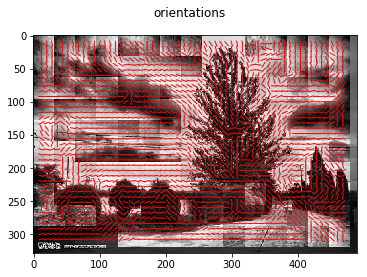

In [33]:
showOrientations(image,orientations,"orientations", 8)

In [35]:
frequencies = np.where(mask == 1.0, estimateFrequencies(image, orientations), -1.0)

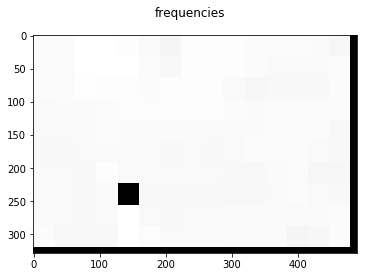

In [36]:
showImage(normalize(frequencies), "frequencies")

In [40]:
image = normalize(gaborFilterSubdivide(image, orientations, frequencies))

In [41]:
image = np.where(mask == 1.0, image, 1.0)

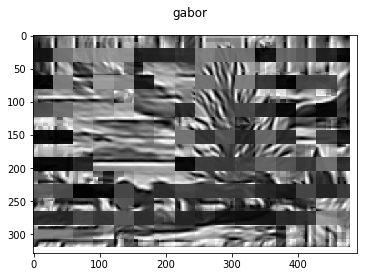

In [42]:
showImage(image, "gabor")

In [43]:
image = gaborFilter(image, orientations, frequencies)

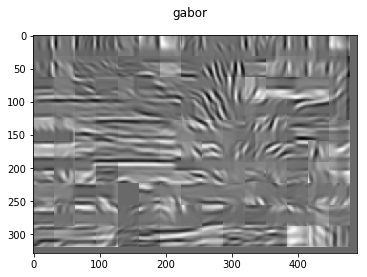

In [44]:
showImage(image, "gabor")